# Condiational Variational AutoEncoder

---

In [1]:
# import packages
import torch
import numpy as np
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from sklearn.datasets import make_swiss_roll
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D 
device = torch.device("cpu")

In [2]:
# get training and test data
data_train, label_train = make_swiss_roll(20000, random_state = 207)
#convert label to binary
label_train = [0 if d[1] < 10 else 1 for d in data_train]
data_test, label_test = make_swiss_roll(20000, random_state = 101)
label_test = [0 if d[1] < 10 else 1 for d in data_test]
#separate data for ploting
cat_0 = data_train[np.array(label_train) == 0]
cat_1 = data_train[np.array(label_train) == 1]

In [3]:
# convert to tensor data loader
epochs = 100
batch_size = 256
train_loader = torch.utils.data.DataLoader(list(zip(data_train, label_train)), 
                                           shuffle = True, batch_size = batch_size)
test_loader = torch.utils.data.DataLoader(list(zip(data_test, label_test)), 
                                          shuffle = True, batch_size = batch_size)

In [5]:
# implementation adapted from pytorch
class CVAE(nn.Module):
    def __init__(self):
        super(CVAE, self).__init__()
        #encoder layers
        #input dim is 3 dimensions + 1 label = 4
        self.fc1 = nn.Linear(4, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc31 = nn.Linear(100, 2) #encodes mean
        self.fc32 = nn.Linear(100, 2) #encodes std
        #decoder layers
        #input dim is 3 latent dimensions 
        self.fc4 = nn.Linear(3, 100)
        self.fc5 = nn.Linear(100, 100)
        self.fc6 = nn.Linear(100, 3)

    def encode(self, x):
        #non-linear transformations for encoder
        h1 = F.relu(self.fc1(x.float()))
        h2 = F.relu(self.fc2(h1))
        #linear transformation for encoder outputs
        return self.fc31(h2), self.fc32(h2)

    def reparameterize(self, mu, logvar):
        #reparametrization trick for sampling latent space
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z, label):
        #non-linear transformation for latent variable input
        #decode by labels
        z = torch.cat((z, label.view(-1,1).float()), dim = 1)
        h3 = F.relu(self.fc4(z))
        h4 = F.relu(self.fc5(h3))
        #linear transformation for decoder output
        return self.fc6(h4)

    def forward(self, x, label):
        #condition by labels
        x = torch.cat((x.float(), label.view(-1,1).float()), dim = 1)
        mu, logvar = self.encode(x.view(-1, 4))
        z = self.reparameterize(mu, logvar)
        return self.decode(z, label), mu, logvar

model = CVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# total loss = np.mean(reconstruction loss + negative KL divergence losses)
def loss_function(recon_x, x, mu, logvar):
    diff = recon_x - x
    ll = 0.5*torch.sum(torch.mul(diff, diff))
    negKL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return torch.mean(ll + negKL)

# training cvae
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, label) in enumerate(train_loader):
        data = data.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data, label)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

# test cvae 
def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, label) in enumerate(test_loader):
            data = data.to(device)
            label = label.to(device)
            recon_batch, mu, logvar = model(data, label)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n], recon_batch[:n].double()])

    test_loss /= len(test_loader.dataset)

In [6]:
def vis_output(generated_latent_space, generated_data, generated_labels):
    #visualize output
    fig = plt.figure(figsize = (30, 8))
    #3d view original data
    ax = fig.add_subplot(1, 3, 1, projection='3d')
    ax.view_init(0, 30)
    ax.scatter(cat_0[:, 0],cat_0[:, 1],cat_0[:, 2], 
               s = 3,color = 'forestgreen', alpha = 0.7, label = 'original data 0')
    ax.scatter(cat_1[:, 0],cat_1[:, 1],cat_1[:, 2], 
               s = 3,color = 'purple', alpha = 0.7, label = 'original data 1')
    ax.set_title('Original Data', fontsize = 20)
    ax.legend()
    #3d view generated data 
    ax = fig.add_subplot(1, 3, 2, projection='3d')
    ax.view_init(0, 30)
    ax.scatter(generated_data[generated_labels.numpy() == 0][:,0], 
               generated_data[generated_labels.numpy() == 0][:,1], 
               generated_data[generated_labels.numpy() == 0][:, 2], 
               s = 3, color = 'forestgreen', alpha = 0.7, label = 'generated data 0')
    ax.scatter(generated_data[generated_labels.numpy() == 1][:,0], 
               generated_data[generated_labels.numpy() == 1][:,1], 
               generated_data[generated_labels.numpy() == 1][:, 2], 
               s = 3, color = 'purple', alpha = 0.7, label = 'generated data 1')
    ax.set_title('Generated Data', fontsize = 20)
    ax.legend()
    #latent space
    ax = fig.add_subplot(1, 3, 3)
    ax.scatter(generated_latent_space[generated_labels.numpy() == 0][:,0], 
               generated_latent_space[generated_labels.numpy() == 0][:, 1], 
               s = 3, color = 'steelblue', alpha = 0.7, label = 'latent space 0')
    ax.scatter(generated_latent_space[generated_labels.numpy() == 1][:,0], 
               generated_latent_space[generated_labels.numpy() == 1][:, 1], 
               s = 3, color = 'darkgray',alpha = 0.7, label = 'latent space 1')
    ax.legend()
    ax.set_title('CVAE Latent Space', fontsize = 20)
    plt.show()

Epoch: 10


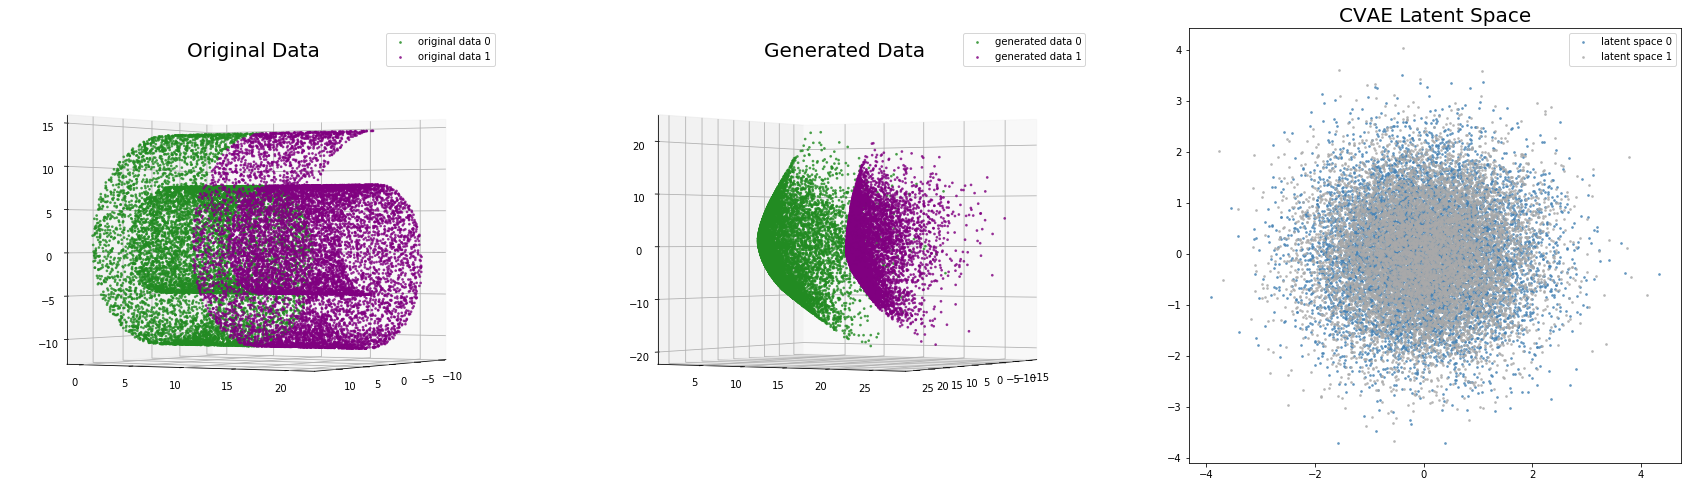

Epoch: 20


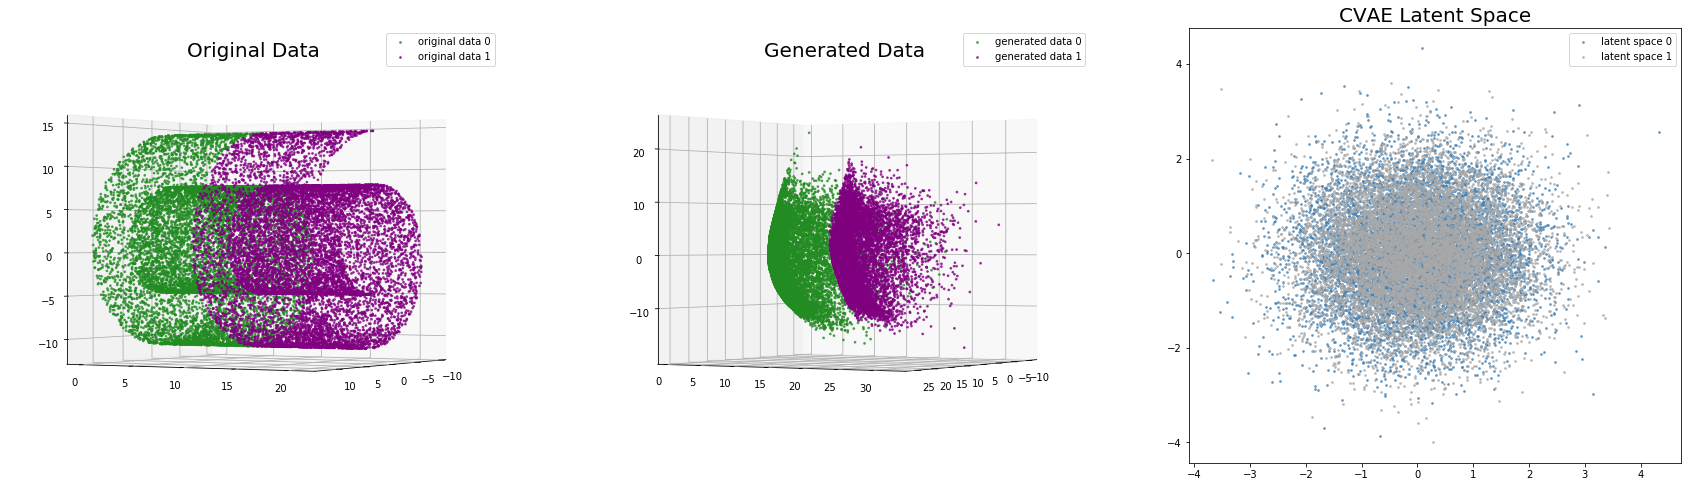

Epoch: 30


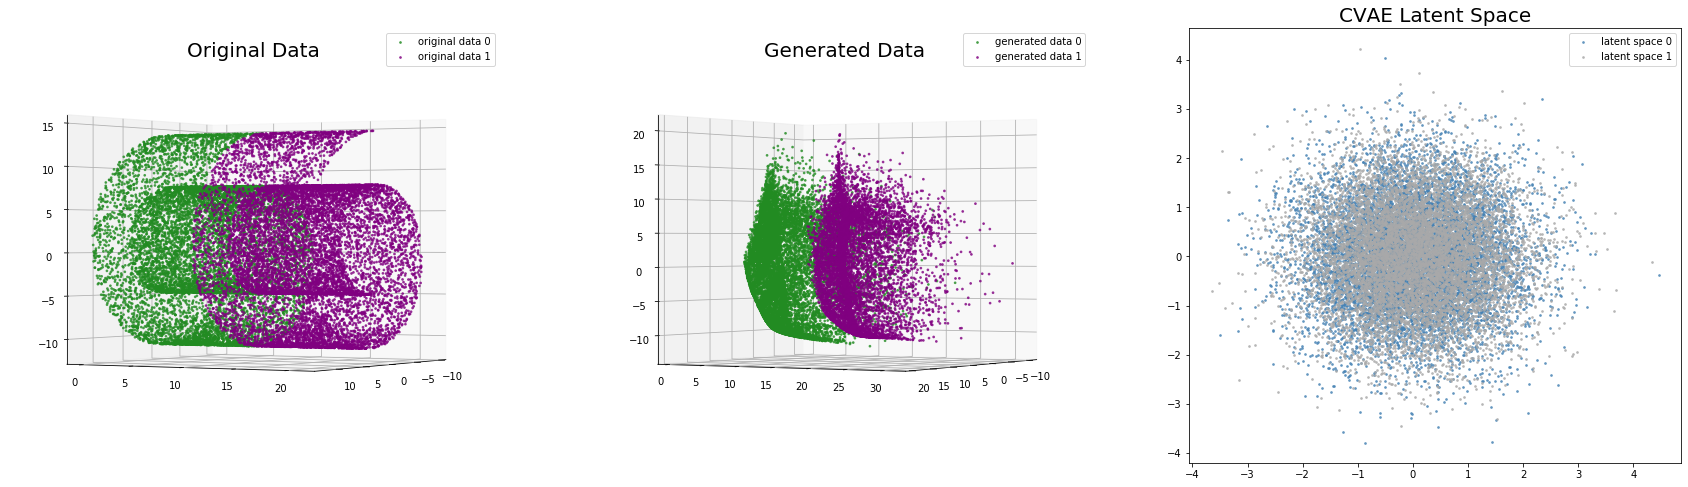

Epoch: 40


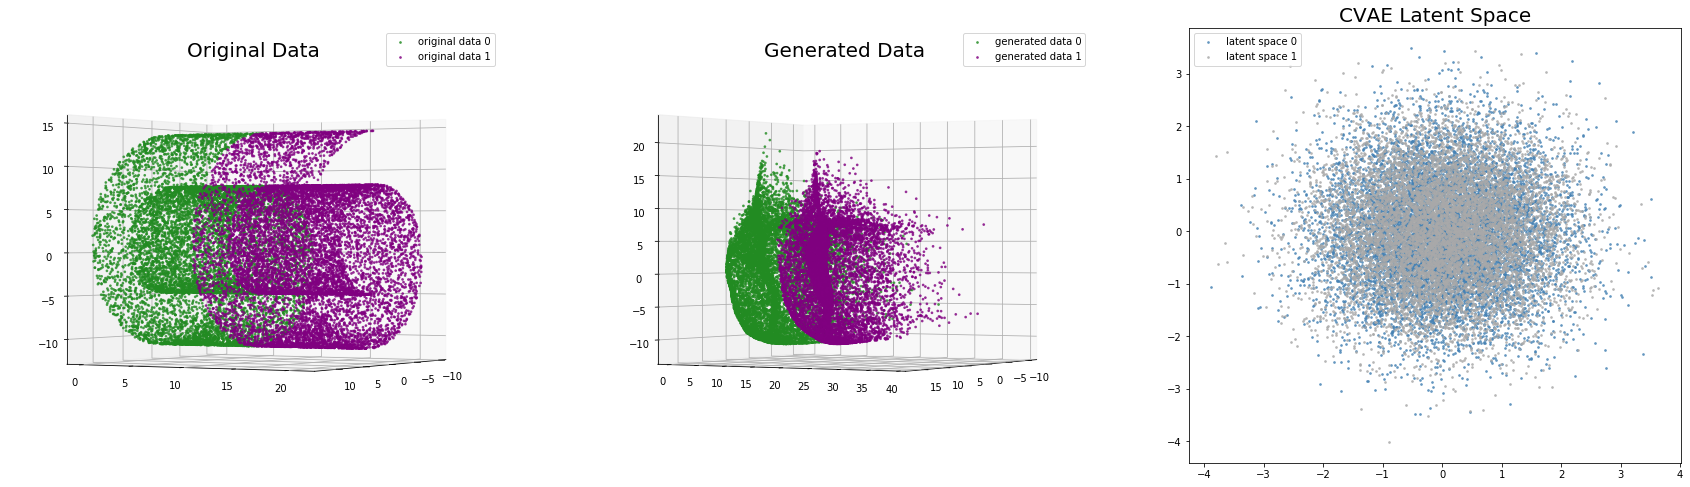

Epoch: 50


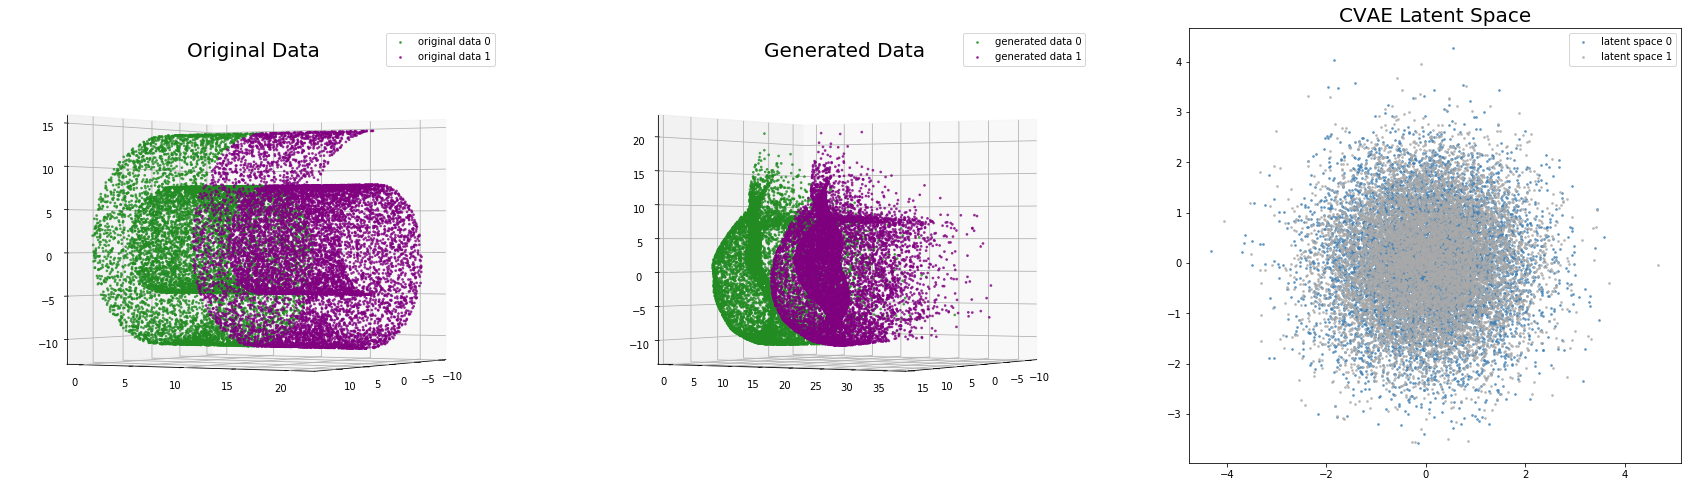

Epoch: 60


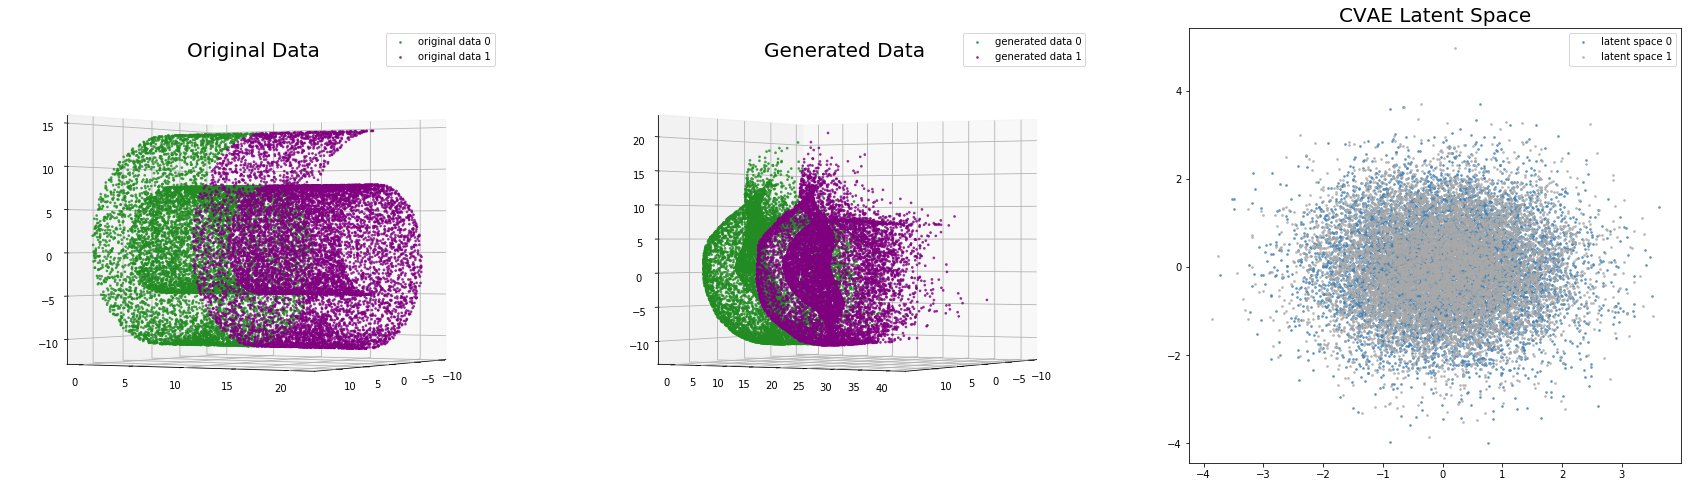

Epoch: 70


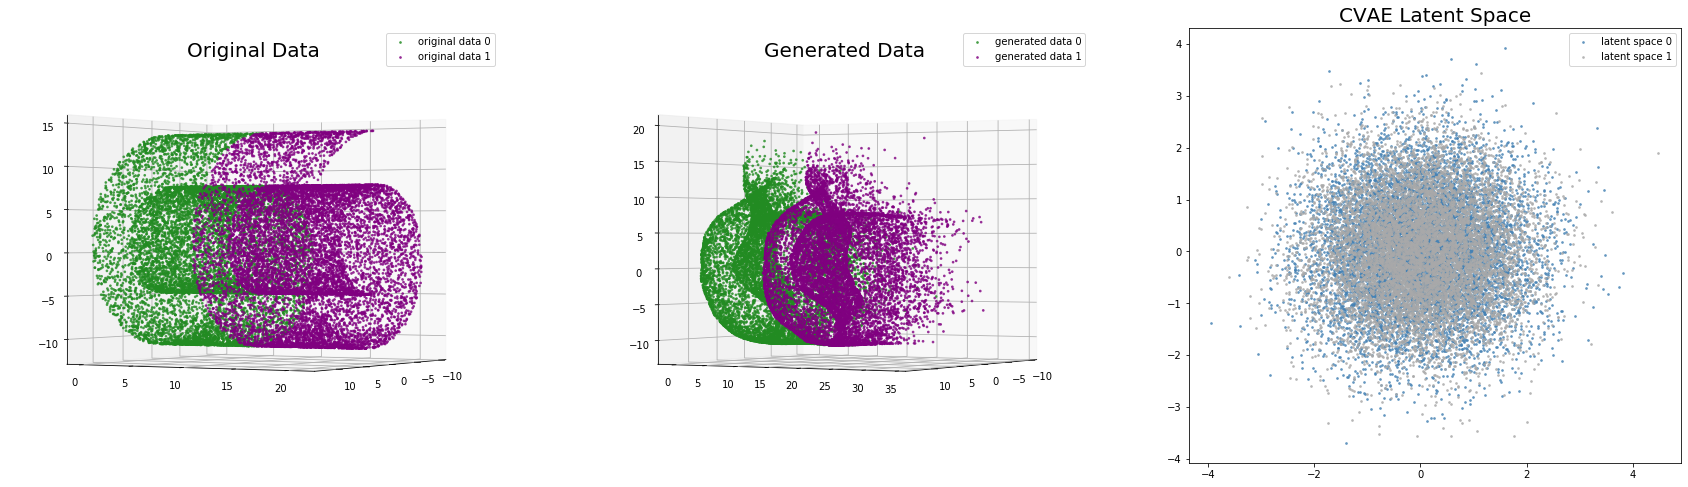

Epoch: 80


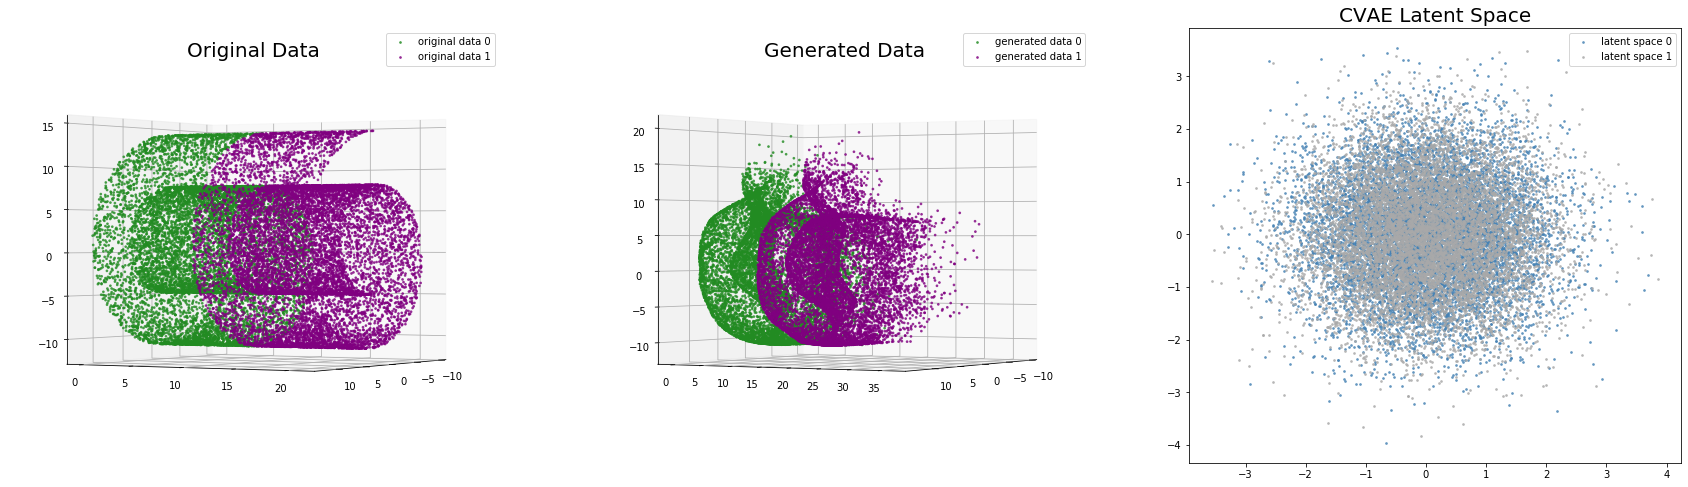

Epoch: 90


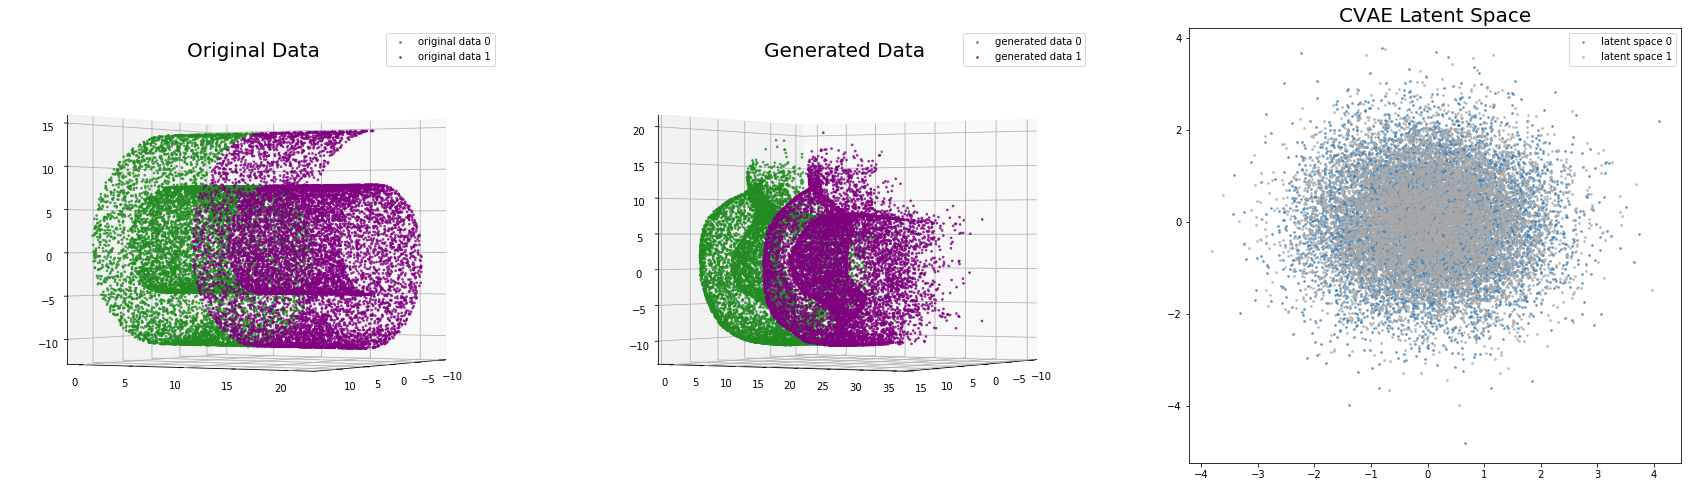

Epoch: 100


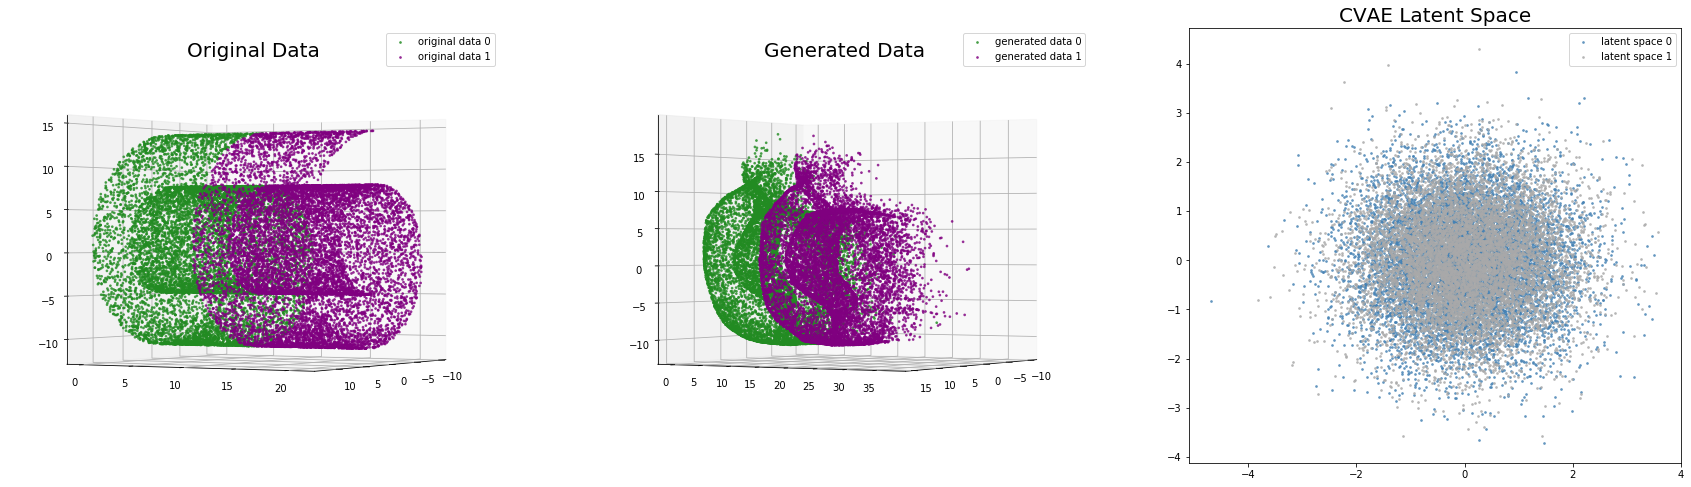

In [7]:
# track training process
for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)
    with torch.no_grad():
        #generate 20000 examples
        sample_latent_space = torch.randn(20000, 2).to(device)
        #randomly sample label
        sample_label = torch.randint(0, 2, (20000,)).to(device)
        sample = model.decode(sample_latent_space, sample_label).cpu()
    if epoch % 10 == 0:
        sample = sample.numpy() #detach to numpy 
        print(f'Epoch: {epoch}')
        vis_output(sample_latent_space.numpy(), sample, sample_label)